In [1]:
import torch
import torchvision
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment

In [2]:
from attacks.analytic_attack import ImprintAttacker
from modifications.imprint import ImprintBlock
from utils.breaching_utils import *

# Attack begins here:

### Initialize your model

In [3]:
trained_model = False
# trained_model = True
num_images = 64
batch_size = 64

class data_cfg_default:
    size = (1_281_167,)
    classes = 1000
    shape = (3, 224, 224)
    normalize = True
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    # cifar10
#     mean = (0.4914672374725342, 0.4822617471218109, 0.4467701315879822)
#     std = (0.24703224003314972, 0.24348513782024384, 0.26158785820007324)
    # cifar100
#     mean = [0.5071598291397095, 0.4866936206817627, 0.44120192527770996]
#     std = [0.2673342823982239, 0.2564384639263153, 0.2761504650115967]

In [4]:
import inversefed
setup = inversefed.utils.system_startup(gpu=7)
defs = inversefed.training_strategy('conservative')

_, trainloader, validloader =  inversefed.construct_dataloaders('ImageNet', defs, data_path='/mnt/7T/Data/Natural/ImageNet/')
# _, trainloader, validloader =  inversefed.construct_dataloaders('CIFAR100', defs, data_path='/mnt/7T/Data/Natural/')


model = torchvision.models.resnet18(pretrained=trained_model)
# model, _ = inversefed.construct_model('ResNet18', num_classes=100, num_channels=3)

if trained_model:
    file = 'ResNet18_ImaegNet_epoch_120.pth'
    model.load_state_dict(torch.load(f'./trained_models/{file}'))

model.to(**setup)
model.eval();

Currently evaluating -------------------------------:
Monday, 20. May 2024 03:07PM
CPUs: 32, GPUs: 8 on user-SYS-421GE-TNRT.
GPU : NVIDIA GeForce RTX 4090


/home/pengxin/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pengxin/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
loss_fn = torch.nn.CrossEntropyLoss()
# It will be modified maliciously:

input_dim = data_cfg_default.shape[0] * data_cfg_default.shape[1] * data_cfg_default.shape[2]
num_bins = 50 # Here we define number of imprint bins

block = ImprintBlock(input_dim, num_bins=num_bins)

model = torch.nn.Sequential(
    torch.nn.Flatten(), block, torch.nn.Unflatten(dim=1, unflattened_size=data_cfg_default.shape), model
)
model.to(**setup)
secret = dict(weight_idx=0, bias_idx=1, shape=tuple(data_cfg_default.shape), structure=block.structure)
secrets = {"ImprintBlock": secret}

In [6]:
# dm = torch.as_tensor(inversefed.consts.cifar10_mean, **setup)[:, None, None]
# ds = torch.as_tensor(inversefed.consts.cifar10_std, **setup)[:, None, None]
# dm = torch.as_tensor(inversefed.consts.cifar100_mean, **setup)[:, None, None]
# ds = torch.as_tensor(inversefed.consts.cifar100_std, **setup)[:, None, None]
dm = torch.as_tensor(inversefed.consts.imagenet_mean, **setup)[:, None, None]
ds = torch.as_tensor(inversefed.consts.imagenet_std, **setup)[:, None, None]


def grid_plot(tensor, labels):
    tensor = tensor.clone().detach()
    tensor.mul_(ds).add_(dm).clamp_(0, 1)
    if num_images == 1:
        fig, axes = plt.subplots(1, 1, figsize=(4, 4))
    elif num_images == 64:
        fig, axes = plt.subplots(num_images // 8, 8, figsize=(12, num_images // 16 * 3))
    else:
        fig, axes = plt.subplots(25, 25, figsize=(12, 12))
    axes = np.reshape(axes, -1)
    for im, l, ax in zip(tensor, labels, axes):
        ax.imshow(im.permute(1, 2, 0).cpu())
#         ax.set_title(l)
        ax.axis('off')
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.savefig(f'out/cifar100_robbing_the_fed_bs_{batch_size}.pdf')

In [7]:
def normalize_tensor(in_feat, eps=1e-10):
    norm_factor = torch.sqrt(torch.sum(in_feat ** 2, dim=1, keepdim=True))
    return in_feat / (norm_factor + eps)


def spatial_average(in_tens, keepdim=True):
    return in_tens.mean([2, 3], keepdim=keepdim)


def compute_batch_order(lpips_scorer, output, ground_truth, setup):
    """Re-order a batch of images according to LPIPS statistics of source batch, trying to match similar images.
    This implementation basically follows the LPIPS.forward method, but for an entire batch."""

    B = output.shape[0]
    L = lpips_scorer.L
    assert ground_truth.shape[0] == B

    with torch.inference_mode():
        # Compute all features [assume sufficient memory is a given]
        features_rec = []
        for input in output:
            input_scaled = lpips_scorer.scaling_layer(input)
            output = lpips_scorer.net.forward(input_scaled)
            layer_features = {}
            for kk in range(L):
                layer_features[kk] = normalize_tensor(output[kk])
            features_rec.append(layer_features)

        features_gt = []
        for input in ground_truth:
            input_scaled = lpips_scorer.scaling_layer(input)
            output = lpips_scorer.net.forward(input_scaled)
            layer_features = {}
            for kk in range(L):
                layer_features[kk] = normalize_tensor(output[kk])
            features_gt.append(layer_features)

        # Compute overall similarities:
        similarity_matrix = torch.zeros(B, B, **setup)
        for idx, x in enumerate(features_gt):
            for idy, y in enumerate(features_rec):
                for kk in range(L):
                    diff = (x[kk] - y[kk]) ** 2
                    similarity_matrix[idx, idy] += spatial_average(lpips_scorer.lins[kk](diff)).squeeze()
    try:
        _, rec_assignment = linear_sum_assignment(similarity_matrix.cpu().numpy(), maximize=False)
    except ValueError:
        print(f"ValueError from similarity matrix {similarity_matrix.cpu().numpy()}")
        print("Returning trivial order...")
        rec_assignment = list(range(B))
    return torch.as_tensor(rec_assignment, device=setup["device"], dtype=torch.long)


### And your dataset (ImageNet by default)

In [8]:
idx = 48

ground_truth_all, labels_all = [], []
while len(labels_all) < num_images:
    img, label = validloader.dataset[idx]
#     idx += 1
    idx += 666
    # skip the images with same labels when images <= num_classes
    if label not in labels_all or len(labels_all) >= 1000:
        labels_all.append(torch.as_tensor((label,), device=setup['device']))
        ground_truth_all.append(img.to(**setup))

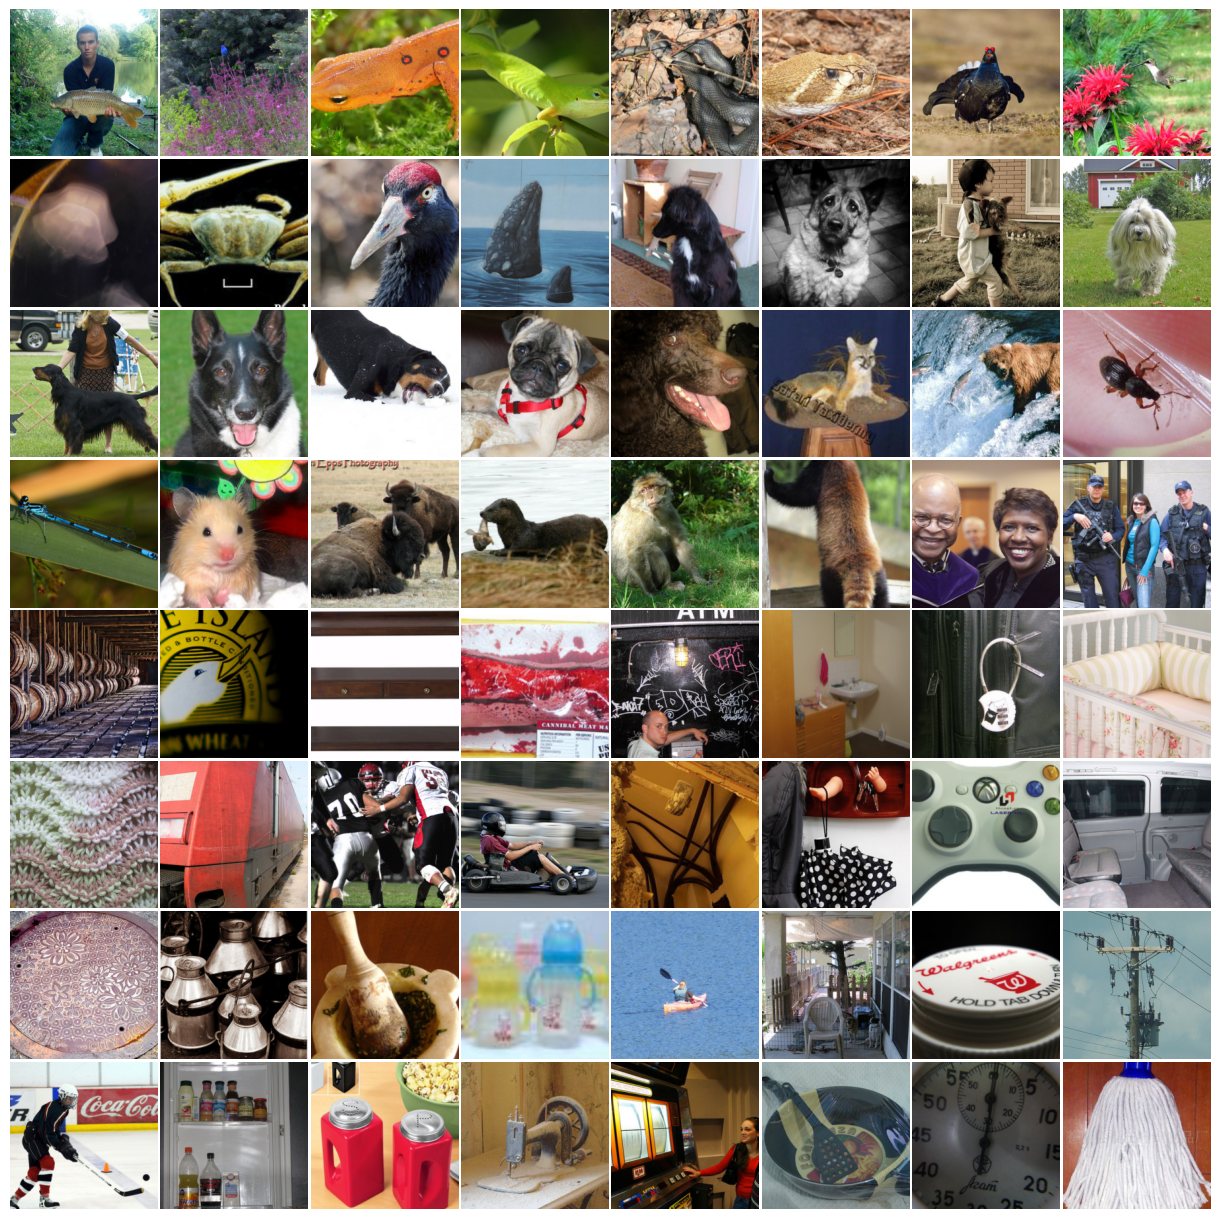

In [9]:
grid_plot(torch.stack(ground_truth_all), labels_all);

### Simulate an attacked FL protocol

In [10]:
# divide into batches
list_all = list(range(num_images))
import random
random.shuffle(list_all)
list_all = [list_all[i:i + batch_size] for i in range(0, len(list_all), batch_size)]
# print(list_all)
reconstructed_user_data_all = []
for lists in list_all:
    data = torch.stack([ground_truth_all[i] for i in lists])
    labels = torch.cat([labels_all[i] for i in lists])
        
    # This is the attacker:
    attacker = ImprintAttacker(model, loss_fn, attack_cfg_default, setup)

    # Server-side computation:
    queries = [dict(parameters=[p for p in model.parameters()], buffers=[b for b in model.buffers()])]
    server_payload = dict(queries=queries, data=data_cfg_default)
    # User-side computation:
    loss = loss_fn(model(data), labels)
    shared_data = dict(
        gradients=[torch.autograd.grad(loss, model.parameters())],
        buffers=None,
        num_data_points=1,
        labels=labels,
        local_hyperparams=None,
    )    
    # Attack:
    reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, secrets, dryrun=False)
#     print(reconstructed_user_data)
    
    reconstructed_user_data_all.append(reconstructed_user_data['data'])

reconstructed_user_data_all = torch.cat(reconstructed_user_data_all, dim=0)

In [11]:
ground_truth_all = torch.stack(ground_truth_all)

In [12]:
import lpips

lpips_scorer = lpips.LPIPS(net="alex").to(**setup)

# order the reconstruction images
order = compute_batch_order(lpips_scorer, reconstructed_user_data_all, ground_truth_all, setup)
reconstructed_user_data_all = reconstructed_user_data_all[order]

test_psnr = inversefed.metrics.psnr(reconstructed_user_data_all, ground_truth_all, factor=1/ds)
test_ssim = inversefed.metrics.cw_ssim(reconstructed_user_data_all, ground_truth_all, scales=5)
lpips_score = lpips_scorer(reconstructed_user_data_all, ground_truth_all, normalize=True)
avg_lpips = lpips_score.mean().item()
print(f"Rec. | PSNR: {test_psnr:4.2f} | SSIM: {test_ssim:2.4f} | LPIPS: {avg_lpips:2.4f}")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/pengxin/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/pengxin/anaconda3/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Rec. | PSNR: 50.24 | SSIM: 0.4773 | LPIPS: 0.4959


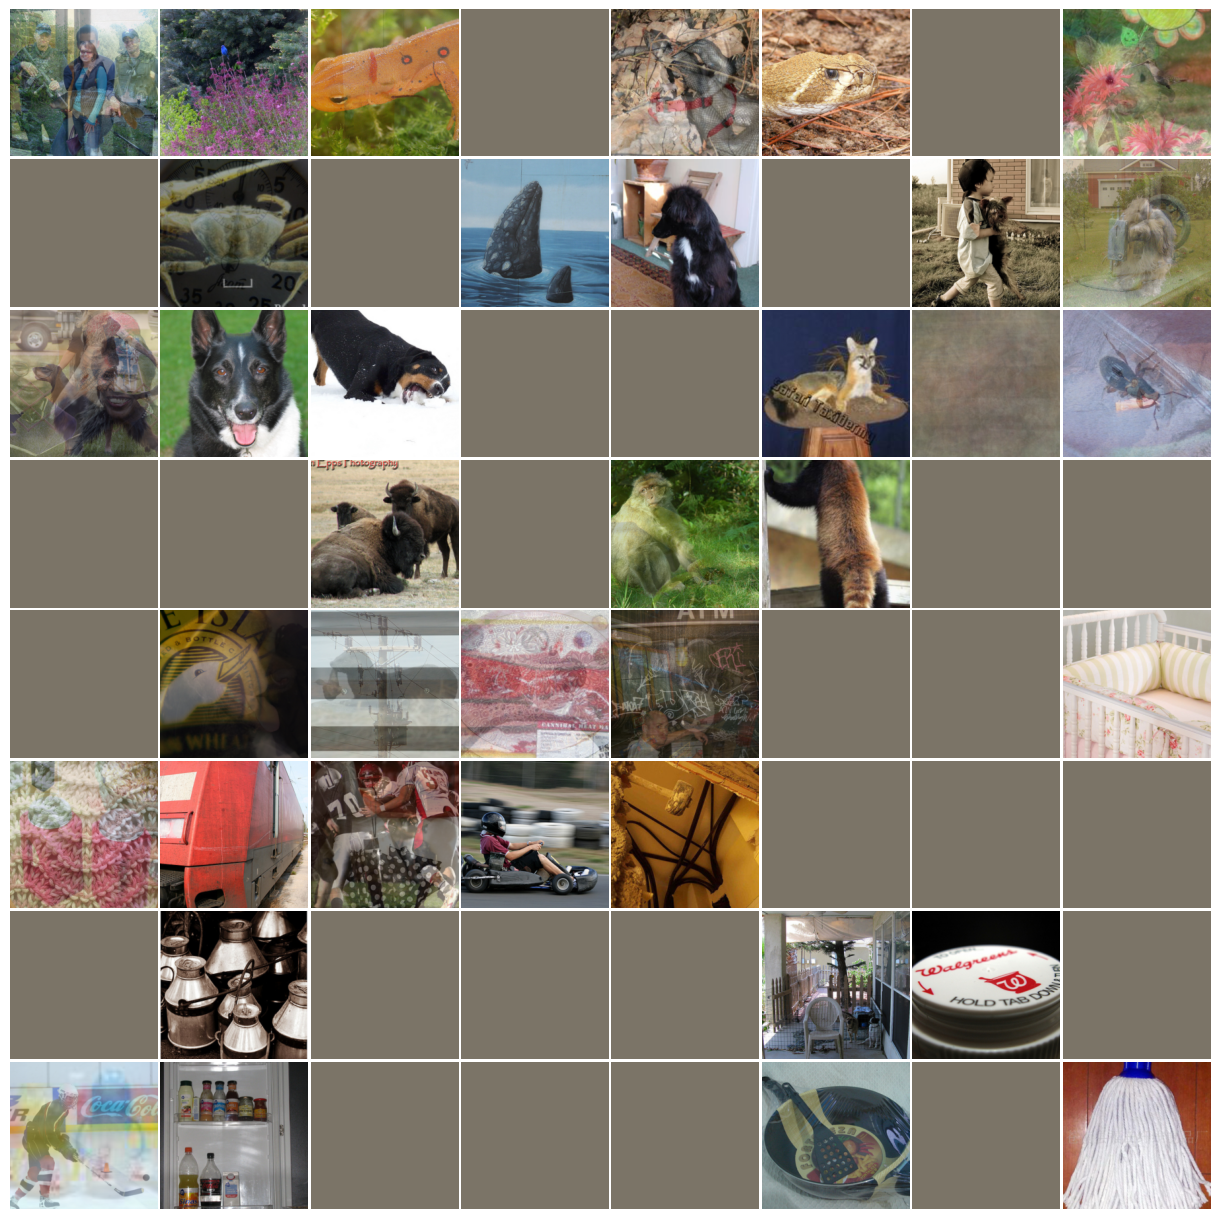

In [13]:
grid_plot(reconstructed_user_data_all, labels_all)